In [1]:
import os

import matplotlib
import numpy as np
import sys
import yaml

sys.path.append('../')
import torch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA

from model import RecurrentNeuralNetwork
from posterior_inference_dataset import Posterior

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def make_signal(N, time_length, signal_length, mu, sigma):
    input_signals = np.zeros([N, time_length+1, 1])
    for i in range(N):
        signal = np.random.normal(mu, sigma, signal_length)
        input_signals[i, :signal_length, 0] = signal
    return input_signals

In [4]:
config_path = '../cfg/posterior/20_1.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)

In [5]:
torch.manual_seed(1)
device = torch.device('cpu')

In [6]:
cfg['MODEL']['SIGMA_PRIOR']

0.6

In [7]:
cfg['MODEL']['ACTIVATION']

'relu'

In [8]:
cfg['MODEL']['SIGMA_NEU'] = 0
model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

if 'ALPHA' not in cfg['MODEL'].keys():
    cfg['MODEL']['ALPHA'] = 0.25

model = RecurrentNeuralNetwork(n_in=1, n_out=1, n_hid=cfg['MODEL']['SIZE'], device=device,
                               alpha_time_scale=cfg['MODEL']['ALPHA'], beta_time_scale=cfg['MODEL']['BETA'],
                               activation=cfg['MODEL']['ACTIVATION'],
                               sigma_neu=cfg['MODEL']['SIGMA_NEU'],
                               sigma_syn=cfg['MODEL']['SIGMA_SYN'],
                               use_bias=cfg['MODEL']['USE_BIAS'],
                               anti_hebbian=cfg['MODEL']['ANTI_HEBB']).to(device)

model_path = f'../trained_model/posterior/{model_name}/epoch_1000.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

model_name:  20_1


RecurrentNeuralNetwork(
  (w_in): Linear(in_features=1, out_features=512, bias=False)
  (w_hh): Linear(in_features=512, out_features=512, bias=True)
  (w_out): Linear(in_features=512, out_features=1, bias=False)
)

In [9]:
cfg['DATALOADER']

{'FIXATION': 5,
 'MEAN_SIGNAL_LENGTH': 25,
 'MU_MAX': 1,
 'MU_MIN': -1,
 'SIGMA_MAX': 0.5,
 'SIGMA_MIN': 0.1,
 'TIME_LENGTH': 36,
 'VARIABLE_SIGNAL_LENGTH': 2,
 'VARIABLE_TIME_LENGTH': 3}

In [18]:
sample_num = 2000

outputs_np = np.zeros(sample_num)
input_signal = make_signal(sample_num, time_length=36, signal_length=25, mu=0, sigma=0.5)
input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])

In [25]:
neural_dynamics = np.zeros((sample_num, 36, model.n_hid))                                                                        
for i in range(sample_num // cfg['TRAIN']['BATCHSIZE']):                                                    
    # hidden_np = np.random.normal(0, 0.5, size=(cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
    hidden_np = np.zeros((cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device)                                                                             
    inputs = torch.from_numpy(input_signal_split[i]).float()                                               
    inputs = inputs.to(device)                                                                             
    hidden_list, outputs, _ = model(inputs, hidden, 36)                                                     
    hidden_list_np = hidden_list.cpu().detach().numpy()                          
    outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
    neural_dynamics[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   

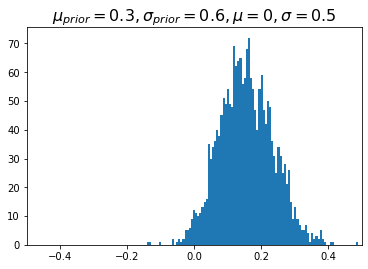

In [21]:
plt.hist(outputs_np, bins=100)
plt.xlim([-0.5, 0.5])
plt.title(r'$\mu_{prior}=0.3, \sigma_{prior}=0.6, \mu=0, \sigma=0.5$', fontsize=16)
plt.show()

In [22]:
import os
os.makedirs('figures', exist_ok=True)

In [26]:
sample_num = 2000

outputs_np = np.zeros(sample_num)
input_signal = make_signal(sample_num, time_length=36, signal_length=25, mu=0, sigma=0.1)
input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])

neural_dynamics = np.zeros((sample_num, 36, model.n_hid))                                                                        
for i in range(sample_num // cfg['TRAIN']['BATCHSIZE']):                                                    
    # hidden_np = np.random.normal(0, 0.5, size=(cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
    hidden_np = np.zeros((cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device)                                                                             
    inputs = torch.from_numpy(input_signal_split[i]).float()                                               
    inputs = inputs.to(device)                                                                             
    hidden_list, outputs, _ = model(inputs, hidden, 36)                                                     
    hidden_list_np = hidden_list.cpu().detach().numpy()                          
    outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
    neural_dynamics[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   
    


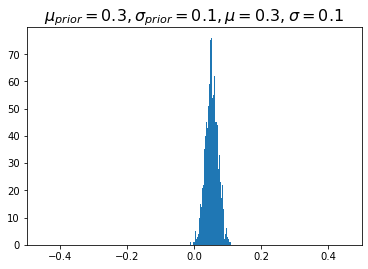

In [27]:
plt.hist(outputs_np, bins=100)
plt.xlim([-0.5, 0.5])
plt.title(r'$\mu_{prior}=0.3, \sigma_{prior}=0.1, \mu=0.3, \sigma=0.1$', fontsize=16)
plt.show()
# plt.savefig('figures/model_8_1_mu_0_sigma_1.0.eps', dpi=200)
# plt.savefig('figures/model_8_1_mu_0_sigma_1.0.png', dpi=200)

mu_posterior: 0.008, sigma_posterior: 0.099


(0.0, 4.544449495863075)

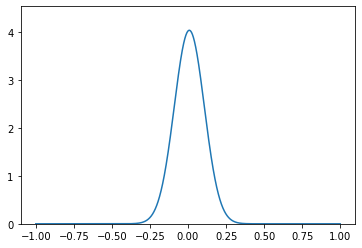

In [166]:
signal_mu = 0
signal_sigma = 0.1
mu_prior = cfg['MODEL']['MU_PRIOR']
sigma_prior = cfg['MODEL']['SIGMA_PRIOR']

mu_posterior = ((signal_sigma ** 2) * mu_prior +
                        (sigma_prior ** 2) * signal_mu) / (sigma_prior ** 2 + signal_sigma ** 2)
sigma_posterior = np.sqrt((signal_sigma ** 2)*(sigma_prior ** 2) / (sigma_prior ** 2 + signal_sigma ** 2) )
print(f'mu_posterior: {mu_posterior:.3f}, sigma_posterior: {sigma_posterior:.3f}')

def gauss(x, mu = 0, sigma = 1):
    return  np.exp(-((x - mu)**2) / (2*(sigma**2))) / (sigma*np.sqrt(2*np.pi))

x = np.arange(-1, 1, 0.001)

# グラフに描く関数
f1 = gauss(x, mu=mu_posterior, sigma=sigma_posterior)
# f1 = gauss(x, mu=mu_posterior, sigma=0.035)

plt.plot(x, f1)
plt.ylim([0, np.max(f1)+0.5])

mu_posterior: 0.123, sigma_posterior: 0.384


(0.0, 1.5386129302236964)

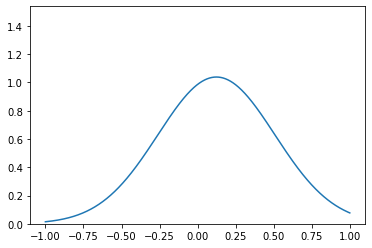

In [167]:
signal_mu = 0
signal_sigma = 0.5
mu_prior = cfg['MODEL']['MU_PRIOR']
sigma_prior = cfg['MODEL']['SIGMA_PRIOR']

mu_posterior = ((signal_sigma ** 2) * mu_prior +
                        (sigma_prior ** 2) * signal_mu) / (sigma_prior ** 2 + signal_sigma ** 2)
sigma_posterior = np.sqrt((signal_sigma ** 2)*(sigma_prior ** 2) / (sigma_prior ** 2 + signal_sigma ** 2) )
print(f'mu_posterior: {mu_posterior:.3f}, sigma_posterior: {sigma_posterior:.3f}')

def gauss(x, mu = 0, sigma = 1):
    return  np.exp(-((x - mu)**2) / (2*(sigma**2))) / (sigma*np.sqrt(2*np.pi))

x = np.arange(-1, 1, 0.001)

# グラフに描く関数
f1 = gauss(x, mu=mu_posterior, sigma=sigma_posterior)
# f1 = gauss(x, mu=mu_posterior, sigma=0.035)

plt.plot(x, f1)
plt.ylim([0, np.max(f1)+0.5])

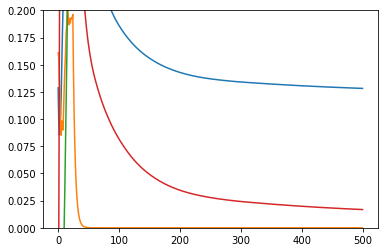

In [56]:
plt.plot(neural_dynamics[0, :, 8])
plt.plot(neural_dynamics[0, :, 76])
plt.plot(neural_dynamics[0, :, 17])
plt.plot(neural_dynamics[0, :, 129])

plt.ylim([0, 0.2])
plt.show()

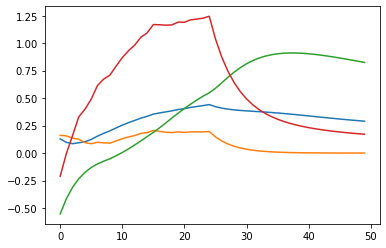

In [52]:
plt.plot(neural_dynamics[0, :50, 8])
plt.plot(neural_dynamics[0, :50, 76])
plt.plot(neural_dynamics[0, :50, 17])
plt.plot(neural_dynamics[0, :50, 129])

# plt.ylim([0, 0.2])
plt.show()

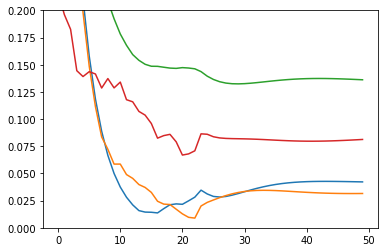

In [186]:
plt.plot(neural_dynamics[0, :50, 8])
plt.plot(neural_dynamics[0, :50, 19])
plt.plot(neural_dynamics[0, :50, 17])
plt.plot(neural_dynamics[0, :50, 26])

plt.ylim([0, 0.2])
plt.show()

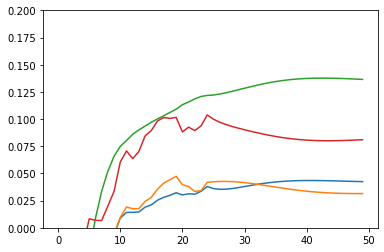

In [187]:
plt.plot(neural_dynamics[1, :50, 8])
plt.plot(neural_dynamics[1, :50, 19])
plt.plot(neural_dynamics[1, :50, 17])
plt.plot(neural_dynamics[1, :50, 26])

plt.ylim([0, 0.2])
plt.show()

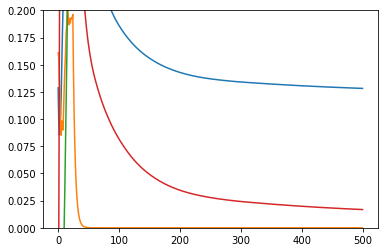

In [57]:
plt.plot(neural_dynamics[0, :, 8])
plt.plot(neural_dynamics[0, :, 76])
plt.plot(neural_dynamics[0, :, 17])
plt.plot(neural_dynamics[0, :, 129])

plt.ylim([0, 0.2])
plt.show()

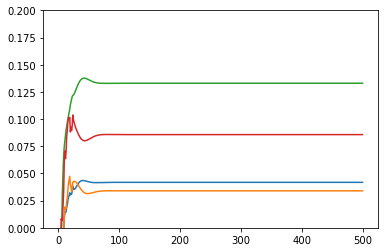

In [192]:
plt.plot(neural_dynamics[1, :, 8])
plt.plot(neural_dynamics[1, :, 19])
plt.plot(neural_dynamics[1, :, 17])
plt.plot(neural_dynamics[1, :, 26])

plt.ylim([0, 0.2])
plt.show()

In [76]:
sample_num = 50

outputs_np = np.zeros(sample_num)
input_signal = make_signal(sample_num, time_length=500, signal_length=25, mu=1, sigma=0.1)
input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])

neural_dynamics = np.zeros((sample_num, 500, model.n_hid))                                                                        
for i in range(sample_num // cfg['TRAIN']['BATCHSIZE']):                                                    
    # hidden_np = np.random.normal(0, 0.5, size=(cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
    hidden_np = np.zeros((cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device)                                                                             
    inputs = torch.from_numpy(input_signal_split[i]).float()                                               
    inputs = inputs.to(device)                                                                             
    hidden_list, outputs, _ = model(inputs, hidden, 500)                                                     
    hidden_list_np = hidden_list.cpu().detach().numpy()                          
    outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
    neural_dynamics[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   

In [77]:
sample_num = 50

outputs_np = np.zeros(sample_num)
input_signal = make_signal(sample_num, time_length=500, signal_length=30, mu=0, sigma=0.5)
input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])

neural_dynamics2 = np.zeros((sample_num, 500, model.n_hid))                                                                        
for i in range(sample_num // cfg['TRAIN']['BATCHSIZE']):                                                    
    # hidden_np = np.random.normal(0, 0.5, size=(cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
    hidden_np = np.zeros((cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device)                                                                             
    inputs = torch.from_numpy(input_signal_split[i]).float()                                               
    inputs = inputs.to(device)                                                                             
    hidden_list, outputs, _ = model(inputs, hidden, 500)                                                     
    hidden_list_np = hidden_list.cpu().detach().numpy()                          
    outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
    neural_dynamics2[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   

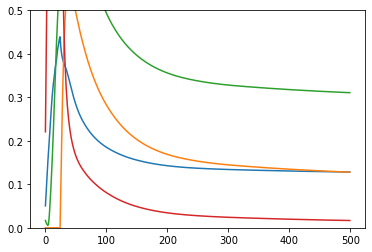

In [78]:
plt.plot(neural_dynamics[0, :, 8])
plt.plot(neural_dynamics[0, :, 34])
plt.plot(neural_dynamics[0, :, 17])
plt.plot(neural_dynamics[0, :, 129])

plt.ylim([0, 0.5])
plt.show()

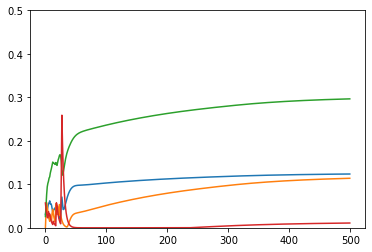

In [79]:
plt.plot(neural_dynamics2[0, :, 8])
plt.plot(neural_dynamics2[0, :, 34])
plt.plot(neural_dynamics2[0, :, 17])
plt.plot(neural_dynamics2[0, :, 129])

plt.ylim([0, 0.5])
plt.show()

In [74]:
neural_dynamics[0, -10:, 34]

array([0.11936593, 0.11936583, 0.11936574, 0.11936563, 0.11936554,
       0.11936544, 0.11936534, 0.11936525, 0.11936516, 0.11936507])

In [75]:
neural_dynamics2[0, -10:, 34]

array([0.11935246, 0.11935245, 0.11935245, 0.11935243, 0.11935243,
       0.11935243, 0.11935242, 0.11935242, 0.11935242, 0.11935242])

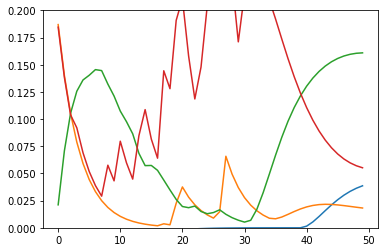

In [190]:
plt.plot(neural_dynamics2[1, :50, 8])
plt.plot(neural_dynamics2[1, :50, 19])
plt.plot(neural_dynamics2[1, :50, 17])
plt.plot(neural_dynamics2[1, :50, 26])

plt.ylim([0, 0.2])
plt.show()

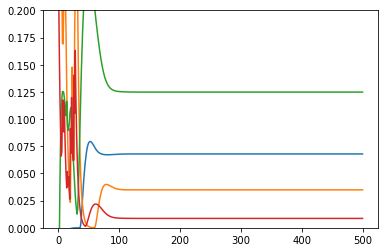

In [227]:
plt.plot(neural_dynamics2[1, :, 8])
plt.plot(neural_dynamics2[1, :, 11])
plt.plot(neural_dynamics2[1, :, 17])
plt.plot(neural_dynamics2[1, :, 27])

plt.ylim([0, 0.2])
plt.show()

In [145]:
print(neural_dynamics2[1, -1, 17])
print(neural_dynamics2[1, -1, 37])

0.09916259348392487
0.018154047429561615


In [147]:
print(neural_dynamics[1, -1, 17])
print(neural_dynamics[1, -1, 37])

0.09916259348392487
0.018154047429561615


In [33]:
sample_num = 3000

outputs_np = np.zeros(sample_num)
input_signal = make_signal(sample_num, time_length=30, signal_length=25, mu=-1, sigma=0.2)
input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])

In [67]:
neural_dynamics = np.zeros((sample_num, 31, model.n_hid))                                                                        
for i in range(sample_num // cfg['TRAIN']['BATCHSIZE']):                                                    
    hidden_np = np.random.normal(0, 0.5, size=(cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device)                                                                             
    inputs = torch.from_numpy(input_signal_split[i]).float()                                               
    inputs = inputs.to(device)                                                                             
    hidden_list, outputs, _ = model(inputs, hidden)                                                     
    hidden_list_np = hidden_list.cpu().detach().numpy()                          
    outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
    neural_dynamics[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   

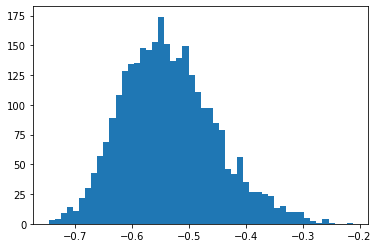

In [68]:
plt.hist(outputs_np, bins=50)
plt.show()

In [70]:
activated = []
for i in range(sample_num):
    tmp = neural_dynamics[0, -1, :]
    activated.append(len(tmp[tmp>0.05]))
print(np.mean(activated) / cfg['MODEL']['SIZE'])

0.146484375


In [76]:
mu_list = [-1, -0.5, 0, 0.5, 1]
sigma_list = [0.1, 0.2, 0.3, 0.4, 0.5]
sample_num = 3000
for mu in mu_list:
    for sigma in sigma_list:
        outputs_np = np.zeros(sample_num)
        input_signal = make_signal(sample_num, time_length=30, signal_length=25, mu=mu, sigma=sigma)
        input_signal_split = np.split(input_signal, sample_num // cfg['TRAIN']['BATCHSIZE'])
        
        neural_dynamics = np.zeros((sample_num, 31, model.n_hid))                                                                        
        for i in range(sample_num // cfg['TRAIN']['BATCHSIZE']):                                                    
            hidden_np = np.random.normal(0, 0.5, size=(cfg['TRAIN']['BATCHSIZE'], cfg['MODEL']['SIZE']))
            hidden = torch.from_numpy(hidden_np).float()                               
            hidden = hidden.to(device)                                                                             
            inputs = torch.from_numpy(input_signal_split[i]).float()                                               
            inputs = inputs.to(device)                                                                             
            hidden_list, outputs, _ = model(inputs, hidden)                                                     
            hidden_list_np = hidden_list.cpu().detach().numpy()                          
            outputs_np[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = outputs.detach().numpy()[:, -1, 0]
            neural_dynamics[i * cfg['TRAIN']['BATCHSIZE']: (i + 1) * cfg['TRAIN']['BATCHSIZE']] = hidden_list_np   
            
        activated = []
        for i in range(sample_num):
            tmp = neural_dynamics[0, -1, :]
            activated.append(len(tmp[tmp>0.05]))
        print(f'mu: {mu:.1f}, sigma: {sigma:.1f}, sparsness: {np.mean(activated) / cfg["MODEL"]["SIZE"]:.5f}')

mu: -1.0, sigma: 0.1, sparsness: 0.14453
mu: -1.0, sigma: 0.2, sparsness: 0.14648
mu: -1.0, sigma: 0.3, sparsness: 0.14453
mu: -1.0, sigma: 0.4, sparsness: 0.09375
mu: -1.0, sigma: 0.5, sparsness: 0.08203
mu: -0.5, sigma: 0.1, sparsness: 0.08008
mu: -0.5, sigma: 0.2, sparsness: 0.06250
mu: -0.5, sigma: 0.3, sparsness: 0.04688
mu: -0.5, sigma: 0.4, sparsness: 0.06836
mu: -0.5, sigma: 0.5, sparsness: 0.08594
mu: 0.0, sigma: 0.1, sparsness: 0.07812
mu: 0.0, sigma: 0.2, sparsness: 0.07422
mu: 0.0, sigma: 0.3, sparsness: 0.08594
mu: 0.0, sigma: 0.4, sparsness: 0.07617
mu: 0.0, sigma: 0.5, sparsness: 0.08203
mu: 0.5, sigma: 0.1, sparsness: 0.13867
mu: 0.5, sigma: 0.2, sparsness: 0.13086
mu: 0.5, sigma: 0.3, sparsness: 0.11328
mu: 0.5, sigma: 0.4, sparsness: 0.11328
mu: 0.5, sigma: 0.5, sparsness: 0.14258
mu: 1.0, sigma: 0.1, sparsness: 0.18359
mu: 1.0, sigma: 0.2, sparsness: 0.16602
mu: 1.0, sigma: 0.3, sparsness: 0.15625
mu: 1.0, sigma: 0.4, sparsness: 0.14844
mu: 1.0, sigma: 0.5, sparsness